### Import the required libraries and modules:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
%cd /content/gdrive/MyDrive/Blood_Vessel_Results/ALL_BEST_RESULTS/BV_OD_Drive

Mounted at /content/gdrive
/content/gdrive/MyDrive/Blood_Vessel_Results/ALL_BEST_RESULTS/BV_OD_Drive


### Unzip the data:

In [ ]:
# !unzip new_data.zip

### Construct the Model:

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters, strides=2):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D(strides)(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters, strides=2):
    x = Conv2DTranspose(num_filters, (2, 2), strides=strides, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_filters=[64, 128, 256, 512, 1024], strides=[2, 2, 2, 2]):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, num_filters[0], strides=strides[0])
    s2, p2 = encoder_block(p1, num_filters[1], strides=strides[1])
    s3, p3 = encoder_block(p2, num_filters[2], strides=strides[2])
    s4, p4 = encoder_block(p3, num_filters[3], strides=strides[3])

    b1 = conv_block(p4, num_filters[4])

    d1 = decoder_block(b1, s4, num_filters[3], strides=strides[3])
    d2 = decoder_block(d1, s3, num_filters[2], strides=strides[2])
    d3 = decoder_block(d2, s2, num_filters[1], strides=strides[1])
    d4 = decoder_block(d3, s1, num_filters[0], strides=strides[0])

    outputs = Conv2D(2, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

input_shape = (512, 512, 3)
model = build_unet(input_shape)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

### Adding the Metrics:

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def DiceBCELoss(y_true, y_pred):

    inputs = tf.keras.layers.Flatten()(y_true)
    targets = tf.keras.layers.Flatten()(y_pred)

    intersection = tf.reduce_sum(inputs * targets)
    dice_loss = 1 - (2.*intersection + smooth)/(tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    BCE = tf.keras.losses.BinaryCrossentropy()
    Dice_BCE = BCE(inputs, targets) + dice_loss

    return Dice_BCE

### Training the Model:

In [ ]:
W = 512
H = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (512, 512, 3)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = x[:,:,0:2] # Discard the last channel 

    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 2])
    return x, y

def tf_dataset(X, Y, batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory to save files """
create_dir("files")

""" Hyperparameters """
batch_size = 2
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model_1024.h5")
csv_path = os.path.join("files", "data_1024.csv")

""" Dataset """
dataset_path = "new_data"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")

train_x, train_y = load_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

train_steps = len(train_x)//batch_size
valid_setps = len(valid_x)//batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_setps += 1

""" Model """
model_1024 = build_unet((H, W, 3), num_filters=[64, 128, 256, 512, 1024], strides=[1, 2, 2, 2])

model_1024.compile(loss=DiceBCELoss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

model_1024.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_setps,
    callbacks=callbacks
)

Train: 80 - 80
Valid: 20 - 20
Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 1.2209 - dice_coef: 0.2021 - iou: 0.1131 - recall: 0.7124 - precision: 0.3184
Epoch 1: val_loss improved from inf to 1.73487, saving model to files/model_1024.h5
40/40 [==============================] - 188s 4s/step - loss: 1.2209 - dice_coef: 0.2021 - iou: 0.1131 - recall: 0.7124 - precision: 0.3184 - val_loss: 1.7349 - val_dice_coef: 0.0914 - val_iou: 0.0479 - val_recall: 1.0000 - val_precision: 0.0739 - lr: 1.0000e-04
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 0.9806 - dice_coef: 0.2839 - iou: 0.1657 - recall: 0.6865 - precision: 0.6815
Epoch 2: val_loss did not improve from 1.73487
40/40 [==============================] - 19s 465ms/step - loss: 0.9806 - dice_coef: 0.2839 - iou: 0.1657 - recall: 0.6865 - precision: 0.6815 - val_loss: 3.0750 - val_dice_coef: 0.0835 - val_iou: 0.0436 - val_recall: 1.0000 - val_precision: 0.0719 - lr: 1.0000e-04
Epoch 3/50
40/40 [=

### Evaluate The Model:

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score, auc
# from metrics import dice_loss, dice_coef, iou
# from utils import get_filenames_sorted

In [ ]:
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = x[:,:,0:2] # Discard the last channel 
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

def save_results(ori_x, ori_y, y_pred, save_image_path, channel):
    line = np.ones((y_pred.shape[0], 10, 3)) * 255

    pred_image = np.zeros((y_pred.shape[0], y_pred.shape[1], 3))
    _y_pred = y_pred[:, :, channel]
    _ori_y = ori_y[:, :, channel]
    pred_image[:, :, 0] = ((_y_pred > 0.5) & (_ori_y <= 128)) * 255
    pred_image[:, :, 1] = ((_y_pred > 0.5) & (_ori_y  > 128)) * 255
    pred_image[:, :, 2] = ((_ori_y  > 128) & (_y_pred <= 0.5 )) * 255

    print(" saving result", save_image_path)
    cv2.imwrite(save_image_path, pred_image)

In [ ]:
from copy import deepcopy

data_dir = "new_data"
od_channel, bv_channel = 0, 1

model_dir = "files"
threshold = 0.1

od_result_dir = f"files_demo_od_{threshold}_1024"
bv_result_dir = f"files_demo_bv_{threshold}_1024"

create_dir(od_result_dir)
create_dir(bv_result_dir)

""" Load the model """
model_file_name = f"{model_dir}/model_1024.h5"
print(model_file_name)
# with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_coef_OD': dice_coef_OD, 'dice_coef_MA': dice_coef_MA, 'dice_loss': dice_loss}):
model = tf.keras.models.load_model(model_file_name, compile = False)

""" Load the dataset """
# dataset_path = os.path.join(data_dir, "test")
# test_x, test_y = get_filenames_sorted(data_dir + "/test/image/", data_dir + "/test/mask/" )

dataset_path = os.path.join("new_data", "test")
test_x, test_y = load_data(dataset_path)

""" Make the prediction and calculate the metrics values """
SCORE_BV, SCORE_OD = [], []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.rsplit("/", 1)[1].rsplit(".", 1)[0]
    print(name)

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred_prob = deepcopy(y_pred)
    y_pred = y_pred > threshold
    y_pred = y_pred.astype(np.float32)

    print(np.max(ori_y), np.max(y))

    """ Saving the images """
    save_image_path_od = f"{od_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_od, od_channel)

    save_image_path_bv = f"{bv_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_bv, bv_channel)


#     """ Calculate the od metrics """
    bv_pred = y_pred[:, :, bv_channel].flatten()
    bv_pred_prob = y_pred_prob[:, :, bv_channel].flatten()
    bv_gt = y[:, :, bv_channel].flatten()
    acc_value = accuracy_score(bv_gt > threshold, bv_pred>threshold)
    f1_value = f1_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    jac_value = jaccard_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    recall_value = recall_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    recall_computed = np.sum((bv_gt > threshold) & (bv_pred > threshold)) / np.sum(bv_gt > threshold)
    precision_value = precision_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    auc_score = auc(bv_gt > threshold, bv_pred_prob)
    SCORE_BV.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed, auc_score])

#     """ Calculate the ma metrics """
    bv_pred = y_pred[:, :, od_channel].flatten()
    bv_pred_prob = y_pred_prob[:, :, bv_channel].flatten()
    bv_gt = y[:, :, od_channel].flatten()
    acc_value = accuracy_score(bv_gt > threshold, bv_pred>threshold)
    f1_value = f1_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    jac_value = jaccard_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    recall_value = recall_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    recall_computed = np.sum((bv_gt > threshold) & (bv_pred > threshold)) / np.sum(bv_gt > threshold)
    precision_value = precision_score(bv_gt > threshold, bv_pred>threshold, labels=[0, 1], average="binary")
    auc_score = auc(bv_gt > threshold, bv_pred_prob)
    SCORE_OD.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, recall_computed, auc_score])
    
print("\n")
for SCORE in [SCORE_OD, SCORE_BV]:
    if SCORE == SCORE_OD:
        print("****** OD ******Metrics")
    else:
        print("****** BV ******Metrics")
    score = [s[1:] for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Threshold:", threshold)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f} (dice score)")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")
    print(f"AUC: {score[5]:0.5f}")

    # """ Saving """
    if SCORE == SCORE_OD:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed", "AUC"])
        df.to_csv(f"{od_result_dir}/score.csv")
    else:
        df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Recall Computed", "AUC"])
        df.to_csv(f"{bv_result_dir}/score.csv")
    print("\n")

files/model_1024.h5


  0%|          | 0/20 [00:00<?, ?it/s]

01_test
255 1.0
 saving result files_demo_od_0.1_1024/01_test.png
 saving result files_demo_bv_0.1_1024/01_test.png


  5%|▌         | 1/20 [00:14<04:33, 14.42s/it]

02_test
255 1.0
 saving result files_demo_od_0.1_1024/02_test.png
 saving result files_demo_bv_0.1_1024/02_test.png


 10%|█         | 2/20 [00:16<02:09,  7.22s/it]

03_test
255 1.0
 saving result files_demo_od_0.1_1024/03_test.png
 saving result files_demo_bv_0.1_1024/03_test.png


 15%|█▌        | 3/20 [00:19<01:26,  5.06s/it]

04_test
255 1.0
 saving result files_demo_od_0.1_1024/04_test.png
 saving result files_demo_bv_0.1_1024/04_test.png


 20%|██        | 4/20 [00:21<01:02,  3.89s/it]

05_test
255 1.0
 saving result files_demo_od_0.1_1024/05_test.png
 saving result files_demo_bv_0.1_1024/05_test.png


 25%|██▌       | 5/20 [00:23<00:47,  3.20s/it]

06_test
255 1.0
 saving result files_demo_od_0.1_1024/06_test.png
 saving result files_demo_bv_0.1_1024/06_test.png


 30%|███       | 6/20 [00:25<00:39,  2.82s/it]

07_test
255 1.0
 saving result files_demo_od_0.1_1024/07_test.png
 saving result files_demo_bv_0.1_1024/07_test.png


 35%|███▌      | 7/20 [00:26<00:32,  2.46s/it]

08_test
255 1.0
 saving result files_demo_od_0.1_1024/08_test.png
 saving result files_demo_bv_0.1_1024/08_test.png


 40%|████      | 8/20 [00:29<00:28,  2.37s/it]

09_test
255 1.0
 saving result files_demo_od_0.1_1024/09_test.png
 saving result files_demo_bv_0.1_1024/09_test.png


 45%|████▌     | 9/20 [00:30<00:24,  2.19s/it]

10_test
255 1.0
 saving result files_demo_od_0.1_1024/10_test.png
 saving result files_demo_bv_0.1_1024/10_test.png


 50%|█████     | 10/20 [00:32<00:20,  2.05s/it]

11_test
255 1.0
 saving result files_demo_od_0.1_1024/11_test.png
 saving result files_demo_bv_0.1_1024/11_test.png


 55%|█████▌    | 11/20 [00:34<00:17,  1.96s/it]

12_test
255 1.0
 saving result files_demo_od_0.1_1024/12_test.png
 saving result files_demo_bv_0.1_1024/12_test.png


 60%|██████    | 12/20 [00:36<00:15,  1.97s/it]

13_test
255 1.0
 saving result files_demo_od_0.1_1024/13_test.png
 saving result files_demo_bv_0.1_1024/13_test.png


 65%|██████▌   | 13/20 [00:38<00:13,  1.89s/it]

14_test
255 1.0
 saving result files_demo_od_0.1_1024/14_test.png
 saving result files_demo_bv_0.1_1024/14_test.png


 70%|███████   | 14/20 [00:40<00:12,  2.04s/it]

15_test
255 1.0
 saving result files_demo_od_0.1_1024/15_test.png
 saving result files_demo_bv_0.1_1024/15_test.png


 75%|███████▌  | 15/20 [00:42<00:10,  2.04s/it]

16_test
255 1.0
 saving result files_demo_od_0.1_1024/16_test.png
 saving result files_demo_bv_0.1_1024/16_test.png


 80%|████████  | 16/20 [00:44<00:08,  2.06s/it]

17_test
255 1.0
 saving result files_demo_od_0.1_1024/17_test.png
 saving result files_demo_bv_0.1_1024/17_test.png


 85%|████████▌ | 17/20 [00:46<00:05,  1.98s/it]

18_test
255 1.0
 saving result files_demo_od_0.1_1024/18_test.png
 saving result files_demo_bv_0.1_1024/18_test.png


 90%|█████████ | 18/20 [00:48<00:03,  1.97s/it]

19_test
255 1.0
 saving result files_demo_od_0.1_1024/19_test.png
 saving result files_demo_bv_0.1_1024/19_test.png


 95%|█████████▌| 19/20 [00:50<00:01,  1.94s/it]

20_test
255 1.0
 saving result files_demo_od_0.1_1024/20_test.png
 saving result files_demo_bv_0.1_1024/20_test.png


100%|██████████| 20/20 [00:51<00:00,  2.60s/it]



****** OD ******Metrics
Threshold: 0.1
Accuracy: 0.99277
F1: 0.75059 (dice score)
Jaccard: 0.65733
Recall: 0.87372
Precision: 0.77264
AUC: 0.87372


****** BV ******Metrics
Threshold: 0.1
Accuracy: 0.95889
F1: 0.80313 (dice score)
Jaccard: 0.67335
Recall: 0.74930
Precision: 0.87674
AUC: 0.74930




In [ ]:
import pandas as pd

df = pd.read_csv("files/data_1024.csv")
df.head()

,epoch,dice_coef,iou,loss,lr,precision,recall,val_dice_coef,val_iou,val_loss,val_precision,val_recall
0,0,0.202149,0.113073,1.220904,0.0001,0.318428,0.712385,0.091413,0.047909,1.734866,0.073860,0.999982
1,1,0.283857,0.165690,0.980607,0.0001,0.681485,0.686526,0.083503,0.043585,3.074975,0.071878,0.999992
2,2,0.323651,0.193388,0.908767,0.0001,0.738640,0.723999,0.084352,0.044043,1.297555,0.000000,0.000000
3,3,0.352439,0.214243,0.858961,0.0001,0.764386,0.736011,0.080731,0.042072,1.248049,0.000000,0.000000
4,4,0.379238,0.234334,0.809424,0.0001,0.795219,0.745659,0.082212,0.042875,1.182664,0.025000,0.000010


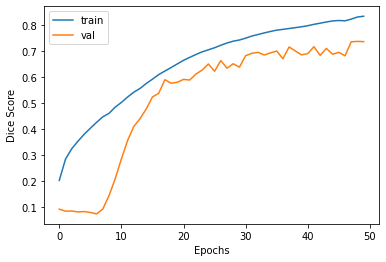

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df["epoch"], df["dice_coef"].values)
plt.plot(df["epoch"], df["val_dice_coef"].values)
plt.legend(["train", "val"])
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.show()

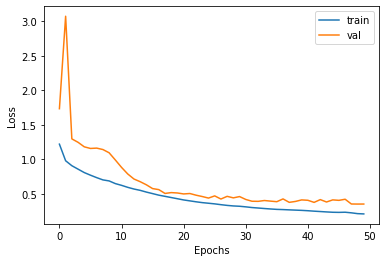

In [ ]:
plt.plot(df["epoch"], df["loss"].values)
plt.plot(df["epoch"], df["val_loss"].values)
plt.legend(["train", "val"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()